In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
%matplotlib inline
dataset_path = "../dataset/lfw_funneled/"

#### Showing sample of images checking to see if there are unusual image

In [2]:
from easyimages import EasyImageList
easy_list = EasyImageList.from_multilevel_folder(dataset_path)
easy_list

<ImageList with 13233 EasyImages [filter OFF]>

In [3]:
easy_list.html(sample=300, size=100, by_class=False)

In [3]:
people = []
features = []
images_aspect_ratios = []
for person in os.listdir(dataset_path):
    path = os.path.join(dataset_path,person)
    label = person
    
    for img in os.listdir(path):
        imgPath = os.path.join(path, img)
        person_img = cv2.imread(imgPath)
        # append image aspect_ratio for ploting
        images_aspect_ratios.append(person_img.shape[1] / person_img.shape[0])
#         person_img = cv2.cvtColor(person_img, cv2.COLOR_BGR2GRAY)
        people.append(person)
        features.append(person_img)

## Plotting images aspec ratios distribution

<AxesSubplot:ylabel='Count'>

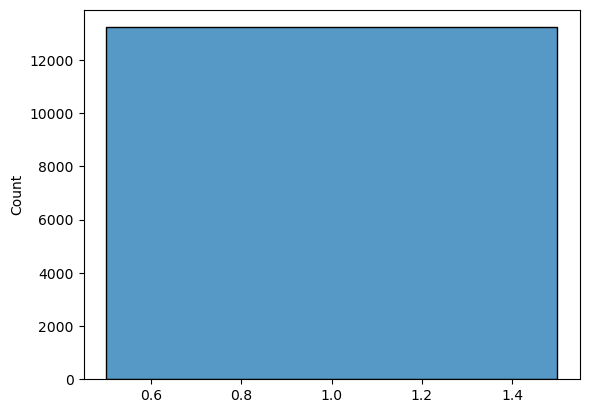

In [5]:
sns.histplot(data=images_aspect_ratios)

<font color='red'> UNIFORM DISTRIBUTION - All of the images have the same aspect ratios </font>

In [68]:
features[0].shape

(250, 250, 3)

create dataframe

In [4]:
df = {'Features': features, 'Target': people}
df = pd.DataFrame(df)
df.head()

,Features,Target
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Walter_Mondale
1,"[[[3, 9, 8], [4, 10, 9], [4, 9, 10], [5, 10, 1...",Walter_Mondale
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Walter_Mondale
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Walter_Mondale
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Walter_Mondale


In [5]:
df['Target'].describe()

count             13233
unique             5749
top       George_W_Bush
freq                530
Name: Target, dtype: object

In [6]:
target_counts = df['Target'].value_counts()
valid_targets = target_counts[target_counts >= 30].index

In [7]:
filtered_df = df[df['Target'].isin(valid_targets)]

In [8]:
filtered_df.reset_index(inplace=True, drop=True)
filtered_df.head()

,Features,Target
0,"[[[15, 37, 65], [15, 39, 67], [19, 43, 73], [2...",John_Negroponte
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",John_Negroponte
2,"[[[2, 0, 0], [2, 0, 0], [2, 0, 0], [2, 0, 0], ...",John_Negroponte
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",John_Negroponte
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",John_Negroponte


Cut frontal face and verify pixel histogram¶

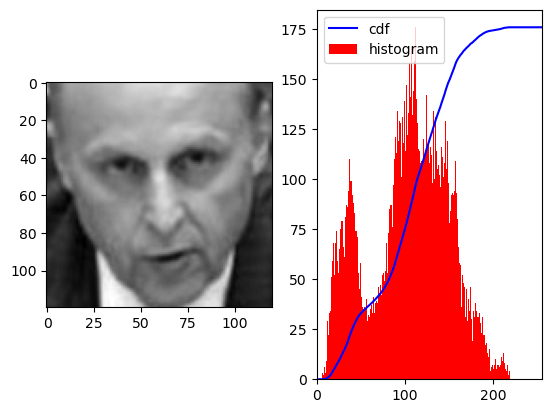

In [9]:
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

img = cv2.cvtColor(filtered_df.iloc[0]['Features'], cv2.COLOR_RGB2GRAY)

faces = face_classifier.detectMultiScale(
    img,     
    scaleFactor=1.2,
    minNeighbors=5,     
    minSize=(20, 20)
)

for x,y,w,h in faces:
    img = img[y:y+h,x:x+w]
    

plt.subplot(1, 2, 1)
plt.imshow(img, cmap = plt.cm.gray)

hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.subplot(1, 2, 2)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(), 256, [0,256], color='r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

### Apply filter and normalize pixel¶

In [10]:
listFace = []
for index in np.arange(len(filtered_df)):
    img = ''
    
    img = cv2.cvtColor(filtered_df.iloc[index]['Features'], cv2.COLOR_RGB2GRAY)
            
    faces = face_classifier.detectMultiScale(
        img,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(20, 20)
    )

    for x,y,w,h in faces:
        img = img[y:y+h,x:x+w]
        
    if img.shape[1] > 0 and img.shape[0] > 0:
        img = cv2.resize(img, (80,100), interpolation = cv2.INTER_AREA)

        hist, bins = np.histogram(img.flatten(), 256, [0, 256])

        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max(),
        
        cdf_m = np.ma.masked_equal(cdf, 0)
        cdf_m = (cdf_m - cdf_m.min())*255 / (cdf_m.max()-cdf_m.min())
        cdf = np.ma.filled(cdf_m, 0).astype('uint8')

        img = cdf[img]
        #_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        listFace.append(img.reshape(80*100))
    else:
        filtered_df.iloc[index, 1] = "NaN"

/tmp/ipykernel_6524/4275568091.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.iloc[index, 1] = "NaN"


In [11]:
filtered_df['Target'].value_counts()

George_W_Bush                513
Colin_Powell                 230
Tony_Blair                   143
Donald_Rumsfeld              117
Gerhard_Schroeder            107
Ariel_Sharon                  74
Hugo_Chavez                   69
Junichiro_Koizumi             59
NaN                           56
Jean_Chretien                 55
John_Ashcroft                 53
Jacques_Chirac                52
Serena_Williams               52
Luiz_Inacio_Lula_da_Silva     48
Vladimir_Putin                48
Gloria_Macapagal_Arroyo       44
Arnold_Schwarzenegger         42
Lleyton_Hewitt                41
Jennifer_Capriati             41
Laura_Bush                    39
Alejandro_Toledo              39
Nestor_Kirchner               36
Andre_Agassi                  36
Hans_Blix                     36
Megawati_Sukarnoputri         33
Alvaro_Uribe                  33
Tom_Ridge                     32
Silvio_Berlusconi             31
Roh_Moo-hyun                  31
Vicente_Fox                   31
David_Beck

In [19]:
filtered_df = filtered_df[filtered_df['Target']!= 'NaN']
filtered_df.shape

(2314, 2)

In [24]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

# For dimensionality reduction
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='linear', class_weight='balanced', decision_function_shape='ovo', gamma='scale')
model = make_pipeline(pca, svc)


QObject::moveToThread: Current thread (0x4b239f0) is not the object's thread (0x1c838aa0).
Cannot move to target thread (0x4b239f0)

QObject::moveToThread: Current thread (0x4b239f0) is not the object's thread (0x1c838aa0).
Cannot move to target thread (0x4b239f0)

QObject::moveToThread: Current thread (0x4b239f0) is not the object's thread (0x1c838aa0).
Cannot move to target thread (0x4b239f0)

QObject::moveToThread: Current thread (0x4b239f0) is not the object's thread (0x1c838aa0).
Cannot move to target thread (0x4b239f0)

QObject::moveToThread: Current thread (0x4b239f0) is not the object's thread (0x1c838aa0).
Cannot move to target thread (0x4b239f0)

QObject::moveToThread: Current thread (0x4b239f0) is not the object's thread (0x1c838aa0).
Cannot move to target thread (0x4b239f0)

QObject::moveToThread: Current thread (0x4b239f0) is not the object's thread (0x1c838aa0).
Cannot move to target thread (0x4b239f0)

QObject::moveToThread: Current thread (0x4b239f0) is not the object's

In [21]:
print(len(listFace), len(filtered_df['Target']))

2314 2314


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(filtered_df['Target'])
X = pd.DataFrame(listFace)

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3, random_state=42)

In [26]:
model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=150, random_state=42, whiten=True)),
                ('svc',
                 SVC(class_weight='balanced', decision_function_shape='ovo',
                     kernel='linear'))])

In [27]:
from sklearn.metrics import accuracy_score

predictions = model.predict(X_test)

accuracy_score(predictions, y_test)

0.42589928057553955

In [28]:
predictions = model.predict(X_train)

accuracy_score(predictions, y_train)

0.9857936998147004

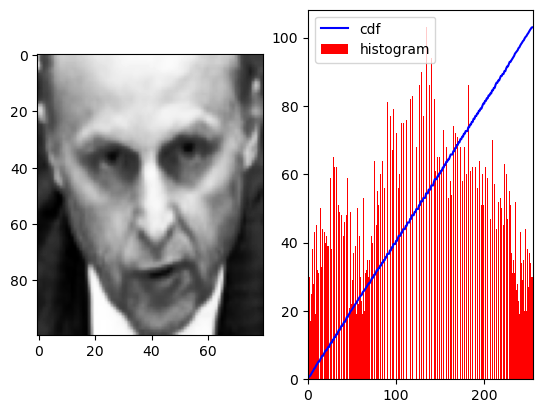

In [59]:
img = listFace[0].reshape(100,80)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap = plt.cm.gray)

hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.subplot(1, 2, 2)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(), 256, [0,256], color='r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


### Transform data for training

In [32]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(filtered_df['Target'])
y.shape

x = pd.DataFrame(listFace)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x.values, y, test_size=0.3)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pc_df = pca.fit_transform(X_train)

In [62]:
pca.explained_variance_ratio_o_

array([0.05457297, 0.04478592, 0.02222736, 0.0174934 , 0.01316161,
       0.01173905, 0.00983351, 0.00956139, 0.00902345, 0.00830651,
       0.00810996, 0.00774713, 0.00751847, 0.00653146, 0.00630711,
       0.00604843, 0.00578679, 0.00557823, 0.00514319, 0.00491461,
       0.00488245, 0.0047561 , 0.00448306, 0.00441405, 0.00417038,
       0.00409693, 0.00390752, 0.00385559, 0.00370684, 0.00355488,
       0.0035053 , 0.00340053, 0.00333859, 0.00331373, 0.00331097,
       0.00323254, 0.00304793, 0.00303151, 0.00298821, 0.00288101])

In [35]:
sum(pca.explained_variance_ratio_) * 100

41.10869980886927

Text(0.5, 1.0, 'Original Image')

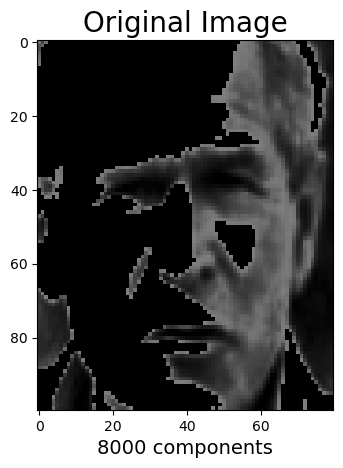

In [36]:
plt.imshow(X_train[0].reshape(100,80),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255))
plt.xlabel(str(100*80) + ' components', fontsize = 14)
plt.title('Original Image', fontsize = 20)

Text(0.5, 1.0, '38.00% Explained Variance')

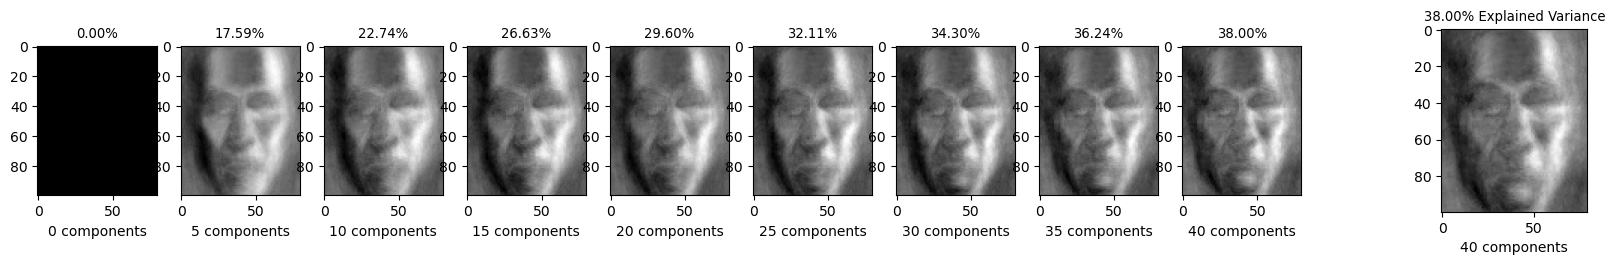

In [37]:
plt.figure(figsize=(20,10))
length_pca = pca.n_components_
for index, value in enumerate(range(0, length_pca, 5)):
    data_original = np.dot(pc_df[:,:value], pca.components_[:value, :])
    plt.subplot(1, int((length_pca/5)+1), int((value/5)+1))
    plt.imshow(data_original[0].reshape(100, 80),
                  cmap = plt.cm.gray)
    plt.xlabel(str(value) + ' components', fontsize = 10)
    plt.title('{:.2f}%'.format(sum(pca.explained_variance_ratio_[:value]) * 100), fontsize = 9.5)

data_original = np.dot(pc_df[:,:40], pca.components_[:40, :])
plt.subplot(1, 9, 9)
plt.imshow(data_original[0].reshape(100, 80),
              cmap = plt.cm.gray)
plt.xlabel(str(40) + ' components', fontsize = 10)
plt.title('{:.2f}% Explained Variance'.format(sum(pca.explained_variance_ratio_[:40]) * 100), fontsize = 9.5)

Text(0.5, 1.0, '38.00 Explained Variance')

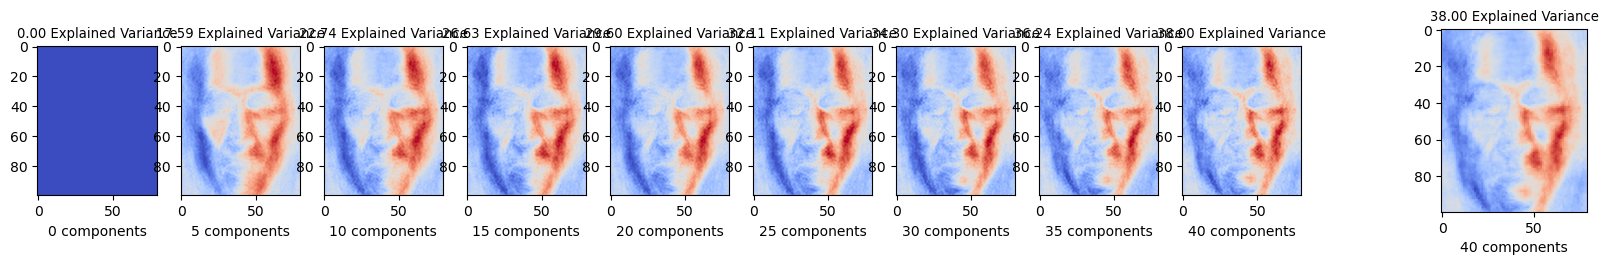

In [38]:
plt.figure(figsize=(20,10))
length_pca = pca.n_components_

for index, value in enumerate(range(0, length_pca, 5)):
    data_original = np.dot(pc_df[:,:value], pca.components_[:value, :]) 
    plt.subplot(1, int((length_pca/5)+1), int((value/5)+1))
    plt.imshow(data_original[0].reshape(100, 80),
                  cmap = plt.cm.coolwarm, interpolation='sinc')
    plt.xlabel(str(value) + ' components', fontsize = 10)
    plt.title('{:.2f} Explained Variance'.format(sum(pca.explained_variance_ratio_[:value]) * 100), fontsize = 9.5)

data_original = np.dot(pc_df[:,:40], pca.components_[:40, :]) 
plt.subplot(1, 9, 9)
plt.imshow(data_original[0].reshape(100, 80),
              cmap = plt.cm.coolwarm)
plt.xlabel(str(40) + ' components', fontsize = 10)
plt.title('{:.2f} Explained Variance'.format(sum(pca.explained_variance_ratio_[:40]) * 100), fontsize = 9.5)

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

lda = lda.fit(pc_df, y_train)
lda_df = lda.transform(pc_df)

In [40]:
lda.explained_variance_ratio_

array([0.3458888 , 0.21417421, 0.14539707, 0.1336898 , 0.07902899,
       0.05023758, 0.03158355])

In [41]:
lda.explained_variance_ratio_.shape

(7,)

In [42]:
lda_df.shape

(919, 7)

In [43]:
pc_test = pca.transform(X_test)
lda.score(pc_test, y_test)

0.5913705583756346